In [1]:
from __future__ import print_function, division, absolute_import
import numpy as np
from scipy.optimize import fmin_l_bfgs_b, least_squares, fmin_slsqp, minimize
import pyfde
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import constrNMPy as cNM
from joblib import Parallel, delayed

sns.set()


def otto_model_create_data(x):
    """
    Run the otto model to generate numerical data
    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    f: frequencies of the data points

    example:
    zr, zj = otto_model_create_test_data(x)
    zr: 1D Numpy array of length f real component of z
    zj: 1D Numpy array of length f imaginary component of z
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    return np.real(ztot), np.abs(np.imag(ztot))


def otto_model_L1_log(x):
    """
    return the L1 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    L1 = (np.sum(np.abs(ir-er))/n) + (np.sum(np.abs(ij-ej))/n)
    if np.isnan(L1):
        return np.inf
    return L1


def otto_model_L2_log(x):
    """
    return the L2 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    e = np.concatenate((ir - er, ij - ej))
    L2 = np.dot(e.T, e)/n
    if np.isnan(L2):
        return np.inf
    return np.sqrt(L2)


def otto_model_L_inf(x):
    """
    return the L infity norm of the otto model for x from some test data
    this returns the maximum deviation in the real + max deviation imaginary

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))

    L_inf = (np.max(np.abs(zr-np.real(ztot)))) +\
            (np.max(np.abs(zj-np.abs(np.imag(ztot)))))
    return L_inf


def otto_model_L2_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    e = (((zr-np.real(ztot))**2)/(np.abs(zmag))) + \
        (((zj-np.abs(np.imag(ztot)))**2)/(np.abs(zmag)))
    L2 = np.dot(e.T, e)
    if np.isnan(L2):
        return np.inf
    return L2


def otto_model_L1_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))

    e = (np.sum((np.abs((zr-np.real(ztot)))))/(n*np.abs(zmag))) + \
        (np.sum((np.abs((zj-np.abs(np.imag(ztot))))))/(n*np.abs(zmag)))
    L1 = np.dot(e.T, e)
    if np.isnan(L1):
        return np.inf
    return L1


def plot_results(f, x_l1, x_l2, x_linf, x_k, title):
    """
    plots the results of all of the optimizations

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # plot the fitted data
    zr_l1, zj_l1 = otto_model_create_data(x_l1)
    zr_l2, zj_l2 = otto_model_create_data(x_l2)
    zr_linf, zj_linf = otto_model_create_data(x_linf)
    zr_lk, zj_lk = otto_model_create_data(x_k)

    plt.figure()
    plt.title(title)
    plt.plot(zr_l1, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(zr_l2, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(zr_linf, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(zr_lk, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(zr, zj, 'xk', label='Test Data')
    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'rj.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(f, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(f, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(f, zj, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'j.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zr_l1, 'o-', label='Log10 L1 norm')
    plt.plot(f, zr_l2, 's-', label='Log10 L2 norm')
    plt.plot(f, zr_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, zr_lk, '<-', label="Kaitlynn's norm")
    plt.plot(f, zr, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_r (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'r.png', dpi=300, bbox_inches='tight')
    plt.show()

    # real residuals
    # er = zr - zr_x
    # imaginary residuals
    # ej = zj - zj_x

    # plt.figure()
    # plt.title(title)
    # plt.semilogx(f, er, 'o')
    # plt.xlabel('$f$')
    # plt.ylabel('Real residuals')
    # plt.grid()

    # plt.figure()
    # ptl.title(title)
    # plt.semilogx(f, ej, 'o')
    # plt.xlabel('$f$')
    # plt.ylabel('Imaginary residuals')
    # plt.grid()
    # plt.show()


def my_opt_fun(obj_function):
    # run differential evolution
    # solver = pyfde.ClassicDE(obj_function, n_dim=5, n_pop=50,
    #                          limits=bounds, minimize=True)
    solver = pyfde.JADE(obj_function, n_dim=5, n_pop=50,
                        limits=bounds, minimize=True)
    solver.c = np.random.random()
    solver.p = np.random.random()
    solver.cr = np.random.random()
    solver.f = np.random.random()
    # solver.cr, solver.f = 1.0, 0.9
    best, fit = solver.run(n_it=1000)
    fit = fit*-1
    # polish with constrained nelder mead simplex optimization
    res_cnm = cNM.constrNM(obj_function, best, bounds[:, 0], bounds[:, 1],
                           full_output=True, xtol=1e-15, ftol=1e-15)
    # if polish better save polish results
    if res_cnm['fopt'] < fit:
        opts = res_cnm['fopt']
        results_x = res_cnm['xopt']
        # print('Polish was better')
    else:
        opts = fit
        results_x = best
        # print('Polish did not help')

    # res_bfgs = fmin_l_bfgs_b(obj_function, best, fprime=None, args=(),
    #                          approx_grad=True, bounds=bounds, m=10,
    #                          factr=10000000.0, pgtol=1e-05, epsilon=1e-05,
    #                          iprint=-1, maxfun=100000, maxiter=15000,
    #                          disp=None, callback=None, maxls=100)
    # if polish better save polish results
    # print(fit, res_bfgs[1])
    # if res_bfgs[1] < fit:
    #     opts = res_bfgs[1]
    #     results_x = res_bfgs[0]
    #     print('Polish was better')
    # else:
    #     opts = fit
    #     results_x = best
    #     print('Polish did not help')

    # res_slsqp = fmin_slsqp(obj_function, best, bounds=bounds, iter=1e10,
    #                        acc=1e-15, iprint=0, disp=None, full_output=1,
    #                        epsilon=1.4901161193847656e-08, callback=None)
    # # if polish better save polish results
    # # print(fit, res_slsqp[1])
    # if res_slsqp[1] < fit:
    #     opts = res_slsqp[1]
    #     results_x = res_slsqp[0]
    #     print('Polish was better')
    # else:
    #     opts = fit
    #     results_x = best

    # res_ls = least_squares(otto_model_L2_Kait_vec, best, bounds=bounds.T, method='trf', ftol=1e-15, xtol=1e-15, gtol=1e-15, loss='linear')
    # # print(res_ls)
    # # if polish better save polish results
    # # print(fit, res_slsqp[1])
    # if 2.0*res_ls.cost < fit:
    #     opts = res_ls.cost*2.0
    #     results_x = res_ls.x
    #     print('Polish was better')
    # else:
    #     opts = fit
    #     results_x = best
    
    # res_tr = minimize(obj_function, best, method='trust-constr', bounds=bounds, tol=None, callback=None, options={'grad': None, 'xtol': 1e-15, 'gtol': 1e-15, 'barrier_tol': 1e-08, 'sparse_jacobian': None, 'maxiter': 1e10, 'verbose': 0, 'finite_diff_rel_step': None, 'initial_constr_penalty': 1.0, 'initial_tr_radius': 1.0, 'initial_barrier_parameter': 0.1, 'initial_barrier_tolerance': 0.1, 'factorization_method': None, 'disp': False})
    # # print(res_ls)
    # # if polish better save polish results
    # # print(fit, res_slsqp[1])
    # if res_tr.cost < fit:
    #     opts = res_tr.cost
    #     results_x = res_tr.x
    #     print('Polish was better')
    # else:
    #     opts = fit
    #     results_x = best
    return np.append(results_x, opts)


def opt_routine(obj_function, runs=50, n_proc=4):
    """
    An optimization routine which first runs a Differential Evolution
    (global optimization), then runs a Bounded BFGS (gradient optimization)
    to polish the result. This processes is repeated for a user defined number
    of runs (which default to 10).

    Input:
    obj_function - Your objective function to minimize
    runs (int: optional) - the number  of times to repeat the optimization
                            process (defaults runs=10)

    Output: results_x, opts, best_x, best_opt
    results_x - a 2D array of all x values from all optimization runs
    opts - a 1D array of the objective values from all optimization runs
    best_x - a 1D array of the best x values found
    best_opt - the best objective value
    """

    # initialize result arrays
    results_x = np.zeros((runs, 5))
    opts = np.zeros(runs)
    t0 = time()
    opt_res = Parallel(n_jobs=n_proc)(delayed(my_opt_fun)(obj_function) for _ in range(runs))  # noqa
    opt_res = np.array(opt_res)
    results_x = opt_res[:, :5]
    opts = opt_res[:, 5]
    t1 = time()
    print('Optimization runtime %0.4f seconds' % (t1-t0))
    # find the best result
    best_index = np.nanargmin(opts)
    best_opt = opts[best_index]
    best_x = results_x[best_index]
    print('Set of optima:', opts)
    print('Best Objective value:', best_opt)
    print('Paramters:', best_x, '\n')
    print('\n')
    return results_x, opts, best_x, best_opt


Optimization runtime 52.3422 seconds
Set of optima: [0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833403 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404]
Best Objective value: 0.018334030854825354
Paramters: [3.96615696e-01 6.32998356e-01 1.71533368e+00 1.00000000e-04
 1.29864999e-10] 



Optimization runtime 49.3944 seconds
Set of optima: [0.02725514 0.02725514 0.02725514 0.02725514 0.02725514 0.02725514
 0.02725514 0.02725514 0.02725514 0.02725514 0.02725514 0.02725514
 0.02725514 0.02725514 0.02725514 0.02725514 0.02725514 0.02725514

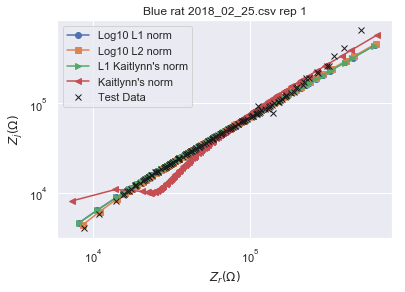

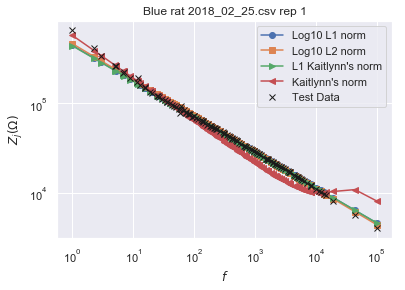

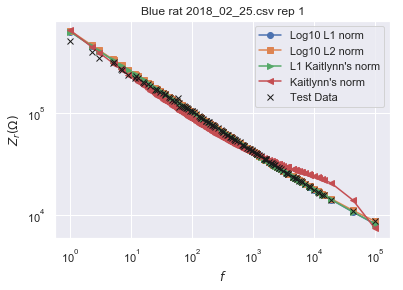

Optimization runtime 50.6670 seconds
Set of optima: [0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009]
Best Objective value: 0.01678008512439229
Paramters: [3.92039529e-01 6.38104269e-01 2.01609895e+00 1.00000000e-04
 7.08841110e-09] 



Optimization runtime 50.8366 seconds
Set of optima: [0.02951914 0.02951914 0.02951914 0.02951914 0.02951914 0.02951914
 0.02951914 0.02951914 0.02951914 0.02951914 0.02951914 0.02951914
 0.02951914 0.02951914 0.02951914 0.02951914 0.02951914 0.02951914


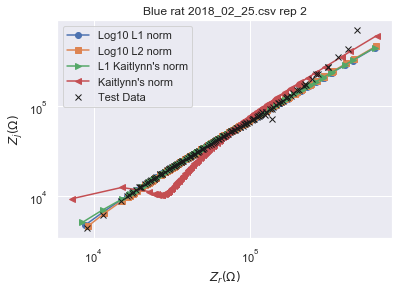

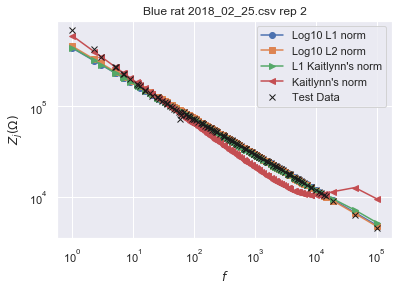

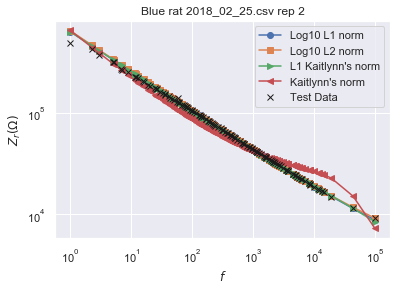

Optimization runtime 66.0867 seconds
Set of optima: [0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536]
Best Objective value: 0.06997536017626077
Paramters: [4.33003264e-01 5.51412906e-01 1.31134514e+01 6.30599355e+29
 1.28123651e-03] 



Optimization runtime 66.0517 seconds
Set of optima: [0.11365234 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234
 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234
 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234


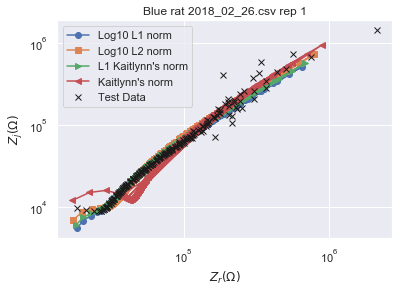

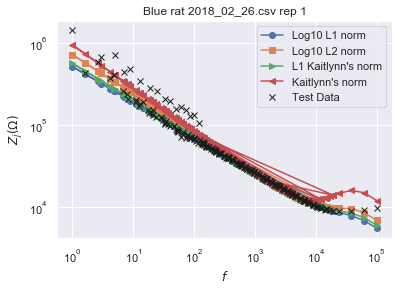

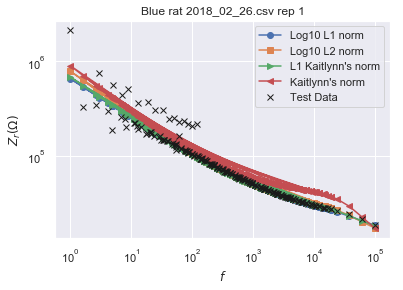

Optimization runtime 64.7362 seconds
Set of optima: [0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536]
Best Objective value: 0.06997536017626077
Paramters: [4.33003264e-01 5.51412906e-01 1.31134514e+01 5.49240538e+29
 1.28123651e-03] 



Optimization runtime 85.4897 seconds
Set of optima: [0.11365234 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234
 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234
 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234


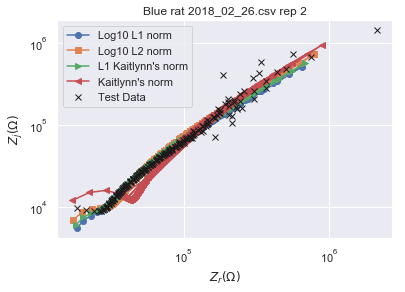

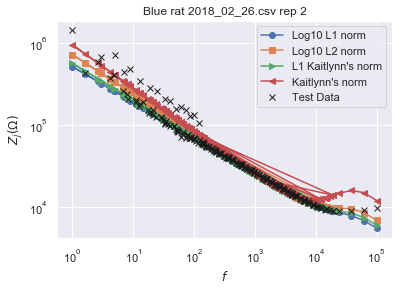

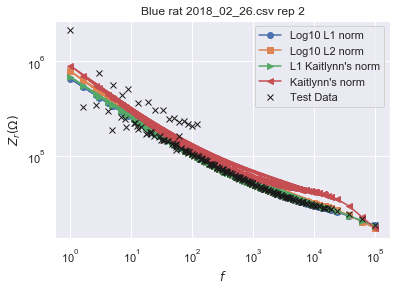

C:\Users\cj\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log10


Optimization runtime 78.0835 seconds
Set of optima: [0.1772434  0.1772434  0.1772434  0.1772434  0.1772434  0.1772434
 0.1772434  0.1772434  0.1772434  0.1772434  0.1772434  0.1772434
 0.1772434  0.1772434  0.17724429 0.1772434  0.1772434  0.1772434
 0.1772434  0.1772434  0.1772434  0.1772434  0.1793694  0.17724429
 0.1772434  0.1772434  0.1772434  0.17724429 0.1772434  0.1772434
 0.1772434  0.1772434  0.1772434  0.1772434  0.1772434  0.1772434
 0.1772434  0.17724429 0.1772434  0.1772434  0.1772434  0.1772434
 0.1772434  0.1772434  0.1772434  0.1772434  0.1772434  0.1772434
 0.1772434  0.1772434 ]
Best Objective value: 0.1772434024209673
Paramters: [7.01586100e-01 8.18264322e-03 1.00000000e-02 6.84001695e+29
 1.04989900e-04] 



Optimization runtime 85.2159 seconds
Set of optima: [0.22069064 0.22069064 0.22069064 0.22069064 0.22069064 0.22069064
 0.22069064 0.22069064 0.22069064 0.22069064 0.22069064 0.22069064
 0.22069064 0.22069064 0.22069064 0.22069064 0.22069064 0.22069064
 0.22069

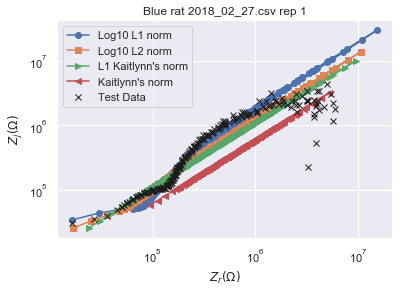

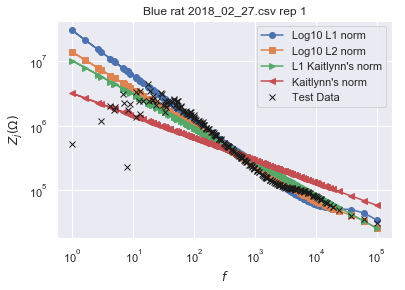

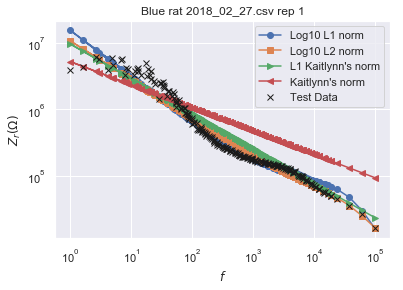

Optimization runtime 84.6293 seconds
Set of optima: [0.18707264 0.18707264 0.18707264 0.18707264 0.18707264 0.18707264
 0.18707264 0.18707264 0.18707264 0.18707264 0.18707264 0.18707264
 0.18707264 0.18707264 0.18707264 0.18707264 0.18707264 0.18707264
 0.18707265 0.18707264 0.18707264 0.18707264 0.18707264 0.18707264
 0.18707264 0.18707264 0.18707264 0.18707264 0.18707264 0.18707264
 0.18707264 0.19843018 0.18707264 0.18707264 0.18707264 0.18707264
 0.18707264 0.18707264 0.18707264 0.18707264 0.18707264 0.18707264
 0.18707264 0.18707264 0.18707264 0.18707264 0.18707264 0.18707264
 0.18707264 0.18707264]
Best Objective value: 0.18707263633172505
Paramters: [7.02409121e-01 8.01561798e-03 1.00000000e-02 1.71360396e+29
 1.05181549e-04] 



Optimization runtime 85.1107 seconds
Set of optima: [0.24097379 0.24097379 0.24097379 0.24097379 0.24097379 0.24097379
 0.24097379 0.24097379 0.24097379 0.24097379 0.24097379 0.24097379
 0.24097379 0.24097379 0.24097379 0.24097379 0.24097379 0.24097379


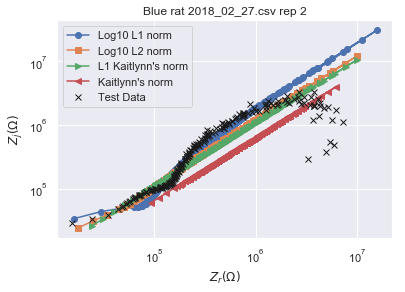

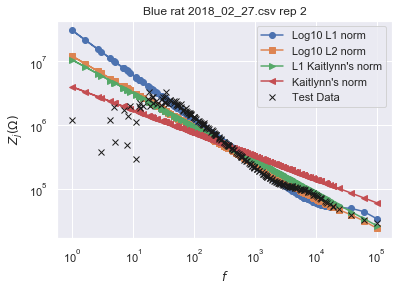

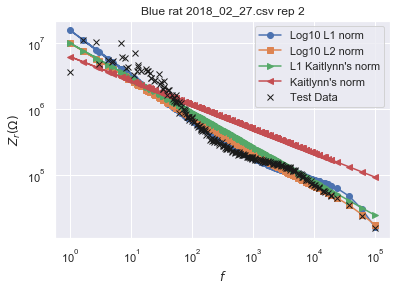

C:\Users\cj\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10


Optimization runtime 83.1336 seconds
Set of optima: [0.16757146 0.16757146 0.16757146 0.16757146 0.16757146 0.16757146
 0.16757146 0.16757146 0.16757146 0.16757146 0.16757146 0.16757146
 0.16757146 0.16757146 0.16757146 0.16757146 0.16757146 0.16757146
 0.16757146 0.16757146 0.16757146 0.16757146 0.16757146 0.16757169
 0.16757146 0.16757146 0.16757146 0.16757146 0.16757146 0.16757146
 0.16757146 0.16757146 0.16757146 0.16757146 0.16757146 0.16757146
 0.16757146 0.16757146 0.16757146 0.16757146 0.16757146 0.16757146
 0.16757146 0.16757146 0.16757146 0.16757146 0.16757146 0.16757146
 0.16757146 0.16757146]
Best Objective value: 0.1675714581597448
Paramters: [7.07653769e-01 6.71601841e-03 1.00000000e-02 1.00000000e+30
 2.97774369e-04] 



Optimization runtime 75.7530 seconds
Set of optima: [0.24344536 0.24344536 0.24344536 0.24344536 0.24344536 0.24344536
 0.24344536 0.24344536 0.24344536 0.24344536 0.24344536 0.24344536
 0.24344536 0.24344536 0.24344536 0.24344536 0.24344536 0.24344536
 

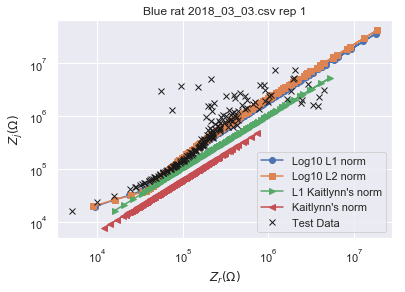

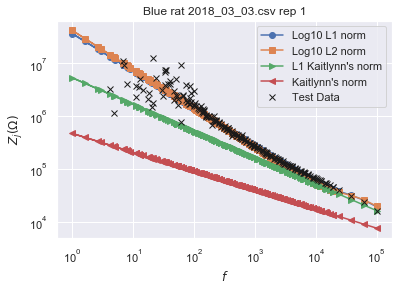

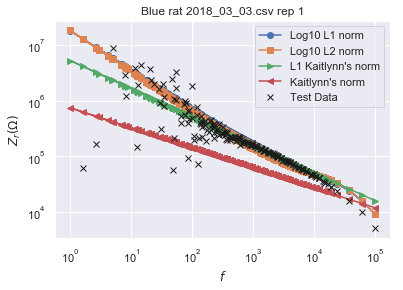

Optimization runtime 81.9863 seconds
Set of optima: [0.17013481 0.17013481 0.17013481 0.17013481 0.17013481 0.17013481
 0.17013481 0.17013481 0.17013481 0.17013481 0.17013481 0.17013481
 0.17013481 0.17013481 0.17013481 0.17013481 0.17013481 0.17013481
 0.17013481 0.17013481 0.17013481 0.17013481 0.17013481 0.17013481
 0.17013481 0.17013481 0.17013481 0.17013481 0.17013481 0.17013481
 0.17013481 0.17013481 0.17013481 0.17013481 0.17013481 0.17013481
 0.17013481 0.17013481 0.17013481 0.17013481 0.17013481 0.17013481
 0.17013481 0.17013481 0.17013481 0.17013481 0.17013481 0.17013481
 0.17013481 0.17013481]
Best Objective value: 0.17013480696762984
Paramters: [7.03555673e-01 6.94834013e-03 1.00000000e-02 2.37774923e+29
 2.87713932e-04] 



Optimization runtime 78.5791 seconds
Set of optima: [0.21228022 0.21228022 0.21228022 0.21228022 0.21228022 0.21228022
 0.21228022 0.21228022 0.21228022 0.21228022 0.21228022 0.21228022
 0.21228022 0.21228022 0.21228022 0.21228022 0.21228022 0.21228022


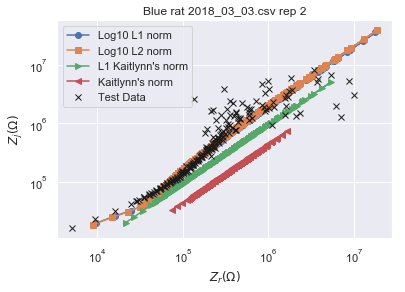

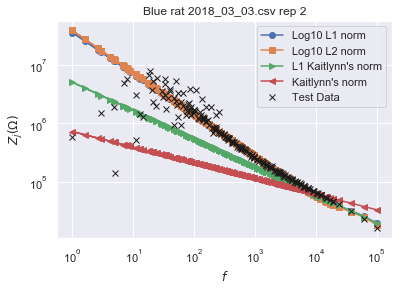

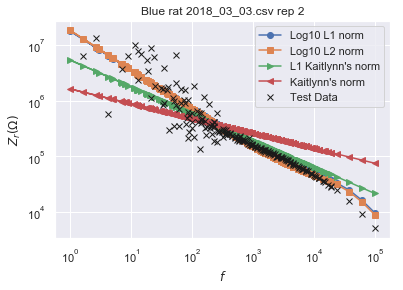

Optimization runtime 80.7124 seconds
Set of optima: [0.0945191 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191
 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191
 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191
 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191
 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191
 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191
 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191 0.0945191
 0.0945191]
Best Objective value: 0.09451909805222289
Paramters: [4.94898983e-01 4.52496557e-02 1.00000000e-02 9.99989917e+29
 7.50143922e-04] 



Optimization runtime 69.5564 seconds
Set of optima: [0.11779618 0.11779618 0.11779618 0.11779618 0.11779618 0.11779618
 0.11779618 0.11779618 0.11779618 0.11779618 0.11779618 0.11779618
 0.11779618 0.11779618 0.11779618 0.11779618 0.11779618 0.11779618
 0.11779618 0.11779618 0.11779618 0.11779618 0.1177

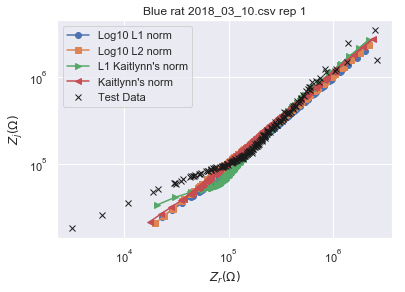

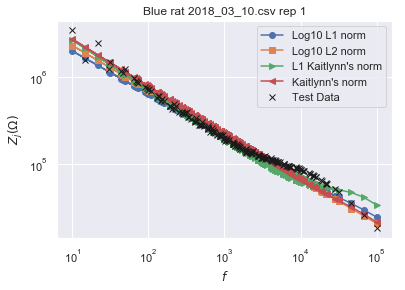

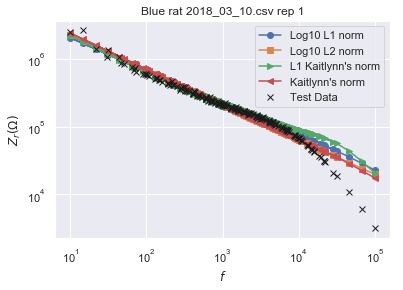

Optimization runtime 69.9268 seconds
Set of optima: [0.10450323 0.10450323 0.10450323 0.10450323 0.10450323 0.10450323
 0.10450323 0.10450323 0.10450323 0.10450323 0.10450323 0.10450323
 0.10450323 0.10450323 0.10450323 0.10450323 0.10450323 0.10450323
 0.10450323 0.10450323 0.10450323 0.10450323 0.10450323 0.10450323
 0.10450323 0.10450323 0.10450323 0.10450323 0.10450323 0.10450323
 0.10450323 0.10450323 0.10450323 0.10450323 0.10450323 0.10450323
 0.10450323 0.10450323 0.10450323 0.10450333 0.10450323 0.10450323
 0.10450323 0.10450323 0.10450323 0.10450323 0.10450323 0.10450323
 0.10450323 0.10450323]
Best Objective value: 0.10450323165062034
Paramters: [4.92826308e-01 4.68223568e-02 1.00000000e-02 8.66809911e+29
 6.25376133e-04] 



Optimization runtime 65.1528 seconds
Set of optima: [0.12327942 0.12327942 0.12327942 0.12327942 0.12327942 0.12327942
 0.12327942 0.12327942 0.12327942 0.12327942 0.12327942 0.12327942
 0.12327942 0.12327942 0.12327942 0.12327942 0.12327942 0.12327942


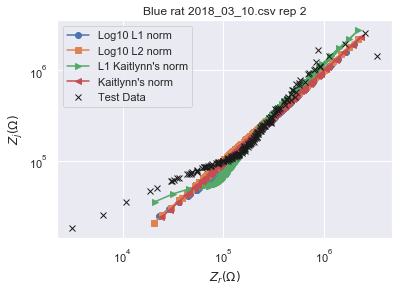

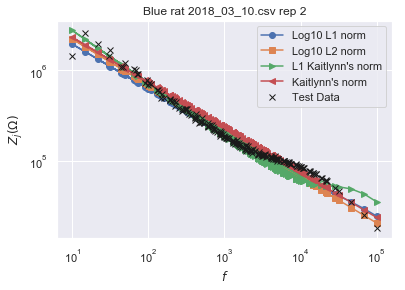

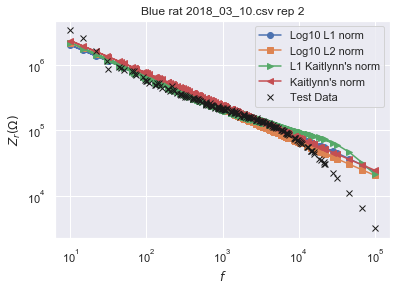

Stored 'res_l1' (ndarray)
Stored 'res_l2' (ndarray)
Stored 'res_lk1' (ndarray)
Stored 'res_lk2' (ndarray)


In [2]:
# optimization bounds
bounds = np.ones((5, 2))*1e-4
bounds[:, 1] = 1000.0
bounds[3, 1] = 1e30
bounds[2, 0] = 1e-2
bounds[4, 0] = 1e-10
bounds[0, 1] = 10.0

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

res_l1 = np.zeros((10, 6))
res_l2 = np.zeros((10, 6))
res_lk1 = np.zeros((10, 6))
res_lk2 = np.zeros((10, 6))

for ind, data in enumerate(data_list):
    dataset = pd.read_csv(data_prefix+data)
    for i in range(2):
        j = i*3
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]
        # Run the optimiziation
        # # generate fake results
        # zr, zj = otto_model_create_data([0.68, 8.8, 34.0, 45.0, 89.0])
        # peform the optimizations

        # remove nans in zr and zj experimental data
        inds = np.where(np.isnan(np.log10(zj)))
        zj = np.delete(zj, inds)
        zr = np.delete(zr, inds)
        f = np.delete(f, inds)
        inds = np.where(np.isnan(np.log10(zr)))
        zj = np.delete(zj, inds)
        zr = np.delete(zr, inds)
        f = np.delete(f, inds)
        n = len(f)
        # run log10 optimizations
        _, _, x_l1, opt_l1 = opt_routine(otto_model_L1_log)
        _, _, x_l2, opt_l2 = opt_routine(otto_model_L2_log)
        
        # reset data values
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]
        # run normal optimizations
        _, _, x_lk1, opt_lk1 = opt_routine(otto_model_L1_Kait)
        _, _, x_lk2, opt_lk2 = opt_routine(otto_model_L2_Kait)
        

        plot_results(f, x_l1, x_l2, x_lk1, x_lk2,
                     'Blue rat ' + data + ' rep ' + str(i+1))
        # # save the results into the array
        res_l1[ind*2 + i, :5] = x_l1
        res_l1[ind*2 + i, 5] = opt_l1
        res_l2[ind*2 + i, :5] = x_l2
        res_l2[ind*2 + i, 5] = opt_l2
        res_lk1[ind*2 + i, :5] = x_lk1
        res_lk1[ind*2 + i, 5] = opt_lk1
        res_lk2[ind*2 + i, :5] = x_lk2
        res_lk2[ind*2 + i, 5] = opt_lk2

%store res_l1
%store res_l2
%store res_lk1
%store res_lk2

# Example results for just one curve

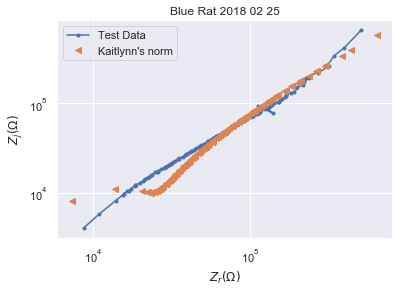

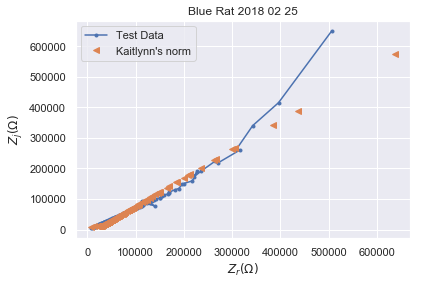

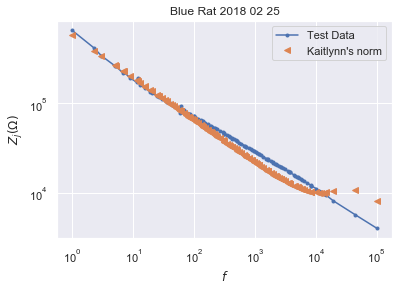

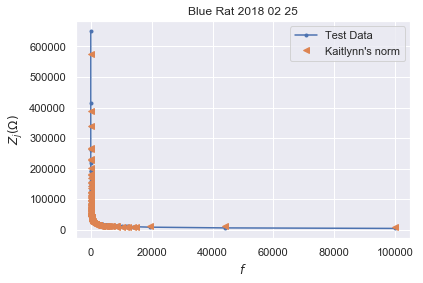

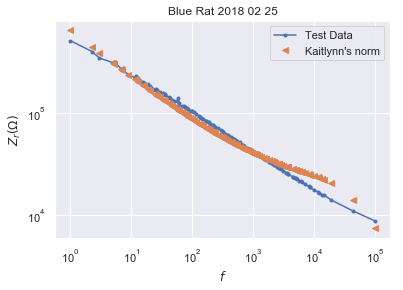

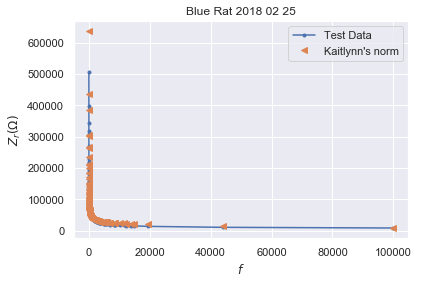

In [3]:
# plot Kaitlynn's norm results
dataset = pd.read_csv(data_prefix+data_list[0])
j = 0*3
f = dataset.values[:, j]
n = len(f)
zr = dataset.values[:, j+1]
zj = dataset.values[:, j+2]
zr_lk, zj_lk = otto_model_create_data(res_lk2[0, :5])
title = 'Blue Rat 2018 02 25'
plt.figure()
plt.title(title)
plt.plot(zr, zj, '.-', label='Test Data')
plt.plot(zr_lk, zj_lk, '<', label="Kaitlynn's norm")

plt.xlabel(r'$Z_r (\Omega)$')
plt.ylabel(r'$Z_j (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logrj.png', dpi=300, bbox_inches='tight')


plt.figure()
plt.title(title)
plt.plot(zr, zj, '.-', label='Test Data')
plt.plot(zr_lk, zj_lk, '<', label="Kaitlynn's norm")

plt.xlabel(r'$Z_r (\Omega)$')
plt.ylabel(r'$Z_j (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'rj.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zj, '.-', label='Test Data')
plt.plot(f, zj_lk, '<', label="Kaitlynn's norm")
plt.xlabel(r'$f$')
plt.ylabel(r'$Z_j (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logj.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zj, '.-', label='Test Data')
plt.plot(f, zj_lk, '<', label="Kaitlynn's norm")
plt.xlabel(r'$f$')
plt.ylabel(r'$Z_j (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'j.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zr, '.-', label='Test Data')
plt.plot(f, zr_lk, '<', label="Kaitlynn's norm")
plt.xlabel(r'$f$')
plt.ylabel(r'$Z_r (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logr.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zr, '.-', label='Test Data')
plt.plot(f, zr_lk, '<', label="Kaitlynn's norm")
plt.xlabel(r'$f$')
plt.ylabel(r'$Z_r (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'r.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
columns = ['alpha CPE phase factor','K CPE magnitude factor', 'ren encapsulation resistance', 'rex extracellular resistance', 'am membrane area in cm**2', 'objective value']
index_rows = ['blue rat 2018_02_25 rep 1', 'blue rat 2018_02_25 rep 2', 'blue rat 2018_02_26 rep 1', 'blue rat 2018_02_26 rep 2', 'blue rat 2018_02_27 rep 1', 'blue rat 2018_02_27 rep 2',
             'blue rat 2018_03_03 rep 1', 'blue rat 2018_03_03 rep 2', 'blue rat 2018_03_10 rep 1', 'blue rat 2018_03_10 rep 2']
pd_l1 = pd.DataFrame(res_l1, index=index_rows, columns=columns)
pd_l2 = pd.DataFrame(res_l2, index=index_rows, columns=columns)
pd_lk1 = pd.DataFrame(res_lk1, index=index_rows, columns=columns)
pd_lk2 = pd.DataFrame(res_lk2, index=index_rows, columns=columns)

# Log10 L1 Norm

In [6]:
pd_l1

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance,rex extracellular resistance,am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.396616,0.632998,1.715334,1.000000e-04,1.298650e-10,0.018334
blue rat 2018_02_25 rep 2,0.392040,0.638104,2.016099,1.000000e-04,7.088411e-09,0.016780
blue rat 2018_02_26 rep 1,0.433003,0.551413,13.113451,6.305994e+29,1.281237e-03,0.069975
blue rat 2018_02_26 rep 2,0.433003,0.551413,13.113451,5.492405e+29,1.281237e-03,0.069975
blue rat 2018_02_27 rep 1,0.701586,0.008183,0.010000,6.840017e+29,1.049899e-04,0.177243
blue rat 2018_02_27 rep 2,0.702409,0.008016,0.010000,1.713604e+29,1.051815e-04,0.187073
blue rat 2018_03_03 rep 1,0.707654,0.006716,0.010000,1.000000e+30,2.977744e-04,0.167571
blue rat 2018_03_03 rep 2,0.703556,0.006948,0.010000,2.377749e+29,2.877139e-04,0.170135
blue rat 2018_03_10 rep 1,0.494899,0.045250,0.010000,9.999899e+29,7.501439e-04,0.094519
blue rat 2018_03_10 rep 2,0.492826,0.046822,0.010000,8.668099e+29,6.253761e-04,0.104503


# Log10 L2 Norm

In [7]:
pd_l2

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance,rex extracellular resistance,am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.404298,0.607267,2.667687,1.000000e-04,1.000534e-10,0.027255
blue rat 2018_02_25 rep 2,0.400011,0.610413,2.813764,9.889884e+29,3.622594e-02,0.029519
blue rat 2018_02_26 rep 1,0.482237,0.391932,12.276697,9.941717e+29,6.369948e-04,0.113652
blue rat 2018_02_26 rep 2,0.482237,0.391932,12.276697,9.961640e+29,6.369948e-04,0.113652
blue rat 2018_02_27 rep 1,0.584869,0.019532,0.010000,8.859220e+29,2.921128e-04,0.220691
blue rat 2018_02_27 rep 2,0.563278,0.022675,0.010000,7.452161e+29,4.582759e-04,0.240974
blue rat 2018_03_03 rep 1,0.737339,0.005657,0.010000,1.651840e+29,2.329522e-04,0.243445
blue rat 2018_03_03 rep 2,0.715574,0.006334,0.010000,7.459565e+29,3.016194e-04,0.212280
blue rat 2018_03_10 rep 1,0.512346,0.037374,0.010000,5.019515e+29,1.000000e+03,0.117796
blue rat 2018_03_10 rep 2,0.507207,0.039588,0.010000,8.729776e+29,1.423954e-02,0.123279


# L1 Kaitlynn's Norm

In [8]:
pd_lk1

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance,rex extracellular resistance,am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.395511,0.639706,1.719379,1.000000e-04,1.039099e-10,5.457185
blue rat 2018_02_25 rep 2,0.395389,0.631858,1.692319,1.000000e+30,5.538361e-03,5.709552
blue rat 2018_02_26 rep 1,0.449077,0.502918,12.979607,9.953982e+29,9.268239e-04,126.752799
blue rat 2018_02_26 rep 2,0.449077,0.502918,12.979607,8.917140e+29,9.268239e-04,126.752799
blue rat 2018_02_27 rep 1,0.520604,0.027520,0.010000,1.000000e-04,1.000000e+03,3216.908778
blue rat 2018_02_27 rep 2,0.520222,0.026532,0.010000,1.000000e-04,1.000000e+03,4425.179606
blue rat 2018_03_03 rep 1,0.503077,0.053056,0.010000,1.000000e-04,1.000000e+03,40618.299751
blue rat 2018_03_03 rep 2,0.479025,0.056436,0.010000,1.000000e-04,1.000000e+03,33113.320305
blue rat 2018_03_10 rep 1,0.568625,0.027684,0.010000,1.000000e+30,1.335521e-04,30.543910
blue rat 2018_03_10 rep 2,0.580028,0.026074,0.010000,9.103249e+29,1.148394e-04,38.084390


# L2 Kaitlynn's (original) norm

In [9]:
pd_lk2

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance,rex extracellular resistance,am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.475518,0.493266,2.059744,2.304957e+29,0.000452,1.214817e+09
blue rat 2018_02_25 rep 2,0.489461,0.469242,1.598685,7.417545e+29,0.000354,2.286608e+09
blue rat 2018_02_26 rep 1,0.529346,0.294484,10.442750,8.391311e+29,0.000263,7.572954e+11
blue rat 2018_02_26 rep 2,0.529346,0.294484,10.442747,2.071402e+29,0.000263,7.572954e+11
blue rat 2018_02_27 rep 1,0.347937,0.086734,0.010000,1.000000e-04,1000.000000,1.070428e+14
blue rat 2018_02_27 rep 2,0.363889,0.069513,0.010000,1.000000e-04,999.999990,1.557465e+14
blue rat 2018_03_03 rep 1,0.358613,0.587762,0.010000,1.000000e-04,1000.000000,2.115047e+15
blue rat 2018_03_03 rep 2,0.266826,0.343793,0.010000,1.000000e-04,999.999977,1.464275e+15
blue rat 2018_03_10 rep 1,0.543016,0.029015,0.010000,7.164325e+29,0.000873,1.437652e+11
blue rat 2018_03_10 rep 2,0.495695,0.039078,0.010000,1.000000e-04,1000.000000,3.620352e+11
